In [1]:
%reload_ext autoreload
%autoreload 2

https://gist.github.com/endolith/255291

In [2]:
import datetime
import uuid
import pyageng
from scipy import signal
import copy

In [3]:
import pyarrow.parquet as pq
import os
import seaborn as sns
import numpy.fft as fft

In [6]:
#pip install tsam
#import tsam.timeseriesaggregation as tsam
#see https://dtaidistance.readthedocs.io/en/latest/usage/installation.html#from-pypi and install from source
#from dtaidistance import clustering
#from dtaidistance import dtw
#from dtaidistance import dtw_visualisation as dtwvis

In [7]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [8]:
import fastai
print(fastai.__version__)

1.0.40.dev0


In [9]:
torch.cuda.set_device(1)

In [10]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [11]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [12]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [13]:
DATE

'20190113'

In [14]:
UID

'0b92ec31'

## Data preparation

In [15]:
path = Path('../input/')

In [16]:
meta_train = pd.read_csv(path/'metadata_train.csv')

In [17]:
meta_train.head(n=2)

signal_id  id_measurement  phase  target
0          0               0      0       0
1          1               0      1       0

In [18]:
meta_train.tail(n=2)

signal_id  id_measurement  phase  target
8710       8710            2903      1       0
8711       8711            2903      2       0

In [29]:
meta_train.shape

(8712, 4)

In [30]:
count_splits=meta_train['target'].value_counts()

In [31]:
count_splits, (count_splits[1]/count_splits[0])*100

(0    8187
 1     525
 Name: target, dtype: int64, 6.412605349945035)

6% bad - need to bump these up in number

check each phase

In [32]:
phase_0_bad=meta_train.loc[(meta_train['target'] == 1) & (meta_train['phase'] == 0)]
phase_1_bad=meta_train.loc[(meta_train['target'] == 1) & (meta_train['phase'] == 1)]
phase_2_bad=meta_train.loc[(meta_train['target'] == 1) & (meta_train['phase'] == 2)]

In [33]:
len(phase_0_bad),len(phase_1_bad),len(phase_2_bad)

(178, 166, 181)

In [34]:
target_bad=meta_train.loc[meta_train['target'] == 1]

In [35]:
all_bad=target_bad.groupby(['id_measurement'])['target'].agg('sum')

In [36]:
len(all_bad)

194

In [37]:
all_bad.head()

id_measurement
1     3
67    2
76    3
90    3
93    3
Name: target, dtype: int64

In [38]:
all_bad=all_bad.reset_index()

In [39]:
list(all_bad)

['id_measurement', 'target']

In [40]:
all_bad.head(n=2)

id_measurement  target
0               1       3
1              67       2

In [41]:

all_bad.target.value_counts()

3    156
2     19
1     19
Name: target, dtype: int64

so, even though most signals with a bad phase have other phases as bad - we cant assume all are bad - so dont think combining 
all signals to one RGB is the way to go

In [42]:
%%time 
# Start small, load in 900 signals and calculate some basic aggregates (mean, sum)
# Read in 900 signals
# Each column contains one signal
subset_train_0_900 = pq.read_pandas(path/'train.parquet', columns=[str(i) for i in range(900)]).to_pandas()

CPU times: user 4.58 s, sys: 2.42 s, total: 7 s
Wall time: 744 ms


In [43]:
# Function to add a few basic aggregations for the different signal ids
def add_cols(df, df_sig):
    for signal in df['signal_id'].tolist():
        df.loc[df['signal_id']==signal,'signal_mean'] = np.mean(df_sig[str(signal)])
        df.loc[df['signal_id']==signal,'signal_sum'] = np.sum(df_sig[str(signal)])
        df.loc[df['signal_id']==signal,'signal_median'] = np.median(df_sig[str(signal)])
        df.loc[df['signal_id']==signal,'signal_ptp'] = np.ptp(df_sig[str(signal)])

In [44]:
meta_train['signal_mean'] = 0
meta_train['signal_sum'] = 0
meta_train['signal_median'] = 0
meta_train['signal_ptp'] = 0
meta_train.head()

signal_id  id_measurement  phase  target  signal_mean  signal_sum  signal_median  signal_ptp
0          0               0      0       0            0           0              0           0
1          1               0      1       0            0           0              0           0
2          2               0      2       0            0           0              0           0
3          3               1      0       1            0           0              0           0
4          4               1      1       1            0           0              0           0

In [45]:
meta_train_0_900 = meta_train[:900]

In [46]:
%%time
add_cols(meta_train_0_900,subset_train_0_900)

CPU times: user 34.1 s, sys: 0 ns, total: 34.1 s
Wall time: 34.1 s


In [47]:
meta_train_0_900.head(n=20)

signal_id  id_measurement  phase  target  signal_mean  signal_sum  signal_median  signal_ptp
0           0               0      0       0    -0.960271     -768217           -1.0          72
1           1               0      1       0    -0.194125     -155300            0.0          56
2           2               0      2       0    -0.043555      -34844            0.0          67
3           3               1      0       1    -0.997401     -797921           -1.0        -127
4           4               1      1       1    -0.175586     -140469            0.0          73
5           5               1      2       1    -0.036004      -28803            0.0         101
6           6               2      0       0    -1.146185     -916948           -1.0         104
7           7               2      1       0    -1.952695    -1562156           -2.0          57
8           8               2      2       0     0.873370      698696            1.0          70
9           9               3      0       0    -1.359634    -1087707           -1.0          -1
10         10               3      1       0     0.728509      582807            1.0         -20
11         11               3      2       0    -0.817065     -653652           -1.0          -1
12         12               4      0       0    -1.011068     -808854           -1.0         -31
13         13               4      1       0    -0.153133     -122506            0.0        -101
14         14               4      2       0    -0.030229      -24183            0.0          -1
15         15               5      0       0    -1.010104     -808083           -1.0          64
16         16               5      1       0    -0.172026     -137621            0.0          45
17         17               5      2       0    -0.034221      -27377            0.0          52
18         18               6      0       0    -1.071144     -856915           -1.0         -44
19         19               6      1       0    -1.936465    -1549172           -2.0        -111

In [48]:
features = meta_train_0_900.columns

In [49]:
features

Index(['signal_id', 'id_measurement', 'phase', 'target', 'signal_mean', 'signal_sum', 'signal_median', 'signal_ptp'], dtype='object')

### Parquet Data

In [50]:
gc.collect()
train_df = pq.read_pandas(path/'train.parquet').to_pandas()

In [51]:
nan = 0
for col in range(len(train_df.columns)):
    nan += np.count_nonzero(train_df.loc[col, :].isnull())
print("train.parquet has {} nulls".format(nan))
print("train.parquet shape: {}".format(train_df.shape))

train.parquet has 0 nulls
train.parquet shape: (800000, 8712)


In [52]:
train_df.head()

0  1   2   3  4   5   6   7  8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  \
0  18  1 -19 -16 -5  19 -15  15 -1 -16  -9  23  -1 -17  16  -8  17 -10  21  -8 -12  -7  23 -15 -20  13   4 -20   1  15  13  -2 -17   5  16 -20   9 -16   7  10 -17   5 -16  18   0  -8  17 -13  -6  18 -17  16   4 -19 -18  -3  21 -19  14   3  -3 -18  18  -4  22 -19 -16  14  -6   3  12 -18 -16  19 -10  13 -21   5  11  15 -24  13   9 -25 -18  -7  23  12   6 -18  15   1 -18  10   7 -18  19 -17  -1  21  -16   -5  -21    6   14   -6   16  -16   17  -13  -16   11  -21    2   16   -7  -10    1   14  -20   -8   21  -12   11  -18    7  -16   16    1   10   11  -20  -11  -11   22   14  -19    5   -6   21  -15  -13   -8   19   -1   -1   -2   -2  -17   22    9   12  -22  -18   14   10    2   14  -19  -14   17   -7   -6   12  -15  -22   10   13   16    2  -20    9   12  -24   14  -22    5   -1   23   -9   13  -21    7  -14   22   -5   -7  -13   21   13    3  -19   -7  -11   19   -9   17  -10  -18    8   11  -22   14    8  -17    1   17   14    0  -17    0  -16   19  -18   -1   14   -4  -20   18   
1  18  0 -19 -17 -6  19 -17  16  0 -15 -10  22   0 -16  17  -7  17 -10  20  -9 -12  -7  24 -14 -20  14   4 -20   1  15  14  -3 -18   5  16 -20   9 -15   7   9 -18   5 -17  18   0 -10  15 -14  -5  19 -16  16   5 -19 -18  -4  21 -21  14   3  -5 -18  20  -6  20 -21 -10  21   1   4  13 -17 -14  20  -8   9 -21   5  11  15 -23  15   9 -24 -17  -7  24  12   5 -18  15   2 -18  11   8 -17  18 -18   0  19  -18   -5  -22    5   13   -2   20  -15   16  -15  -16   11  -24    2   18   -6  -10    1   15  -19   -6   21  -10   11  -18    6  -16   15    1   10   12  -18   -9  -11   23   13  -21    4   -8   23  -14  -11   -7   20    1    0    3   -2  -17   22    8   10  -29  -18   14   11    2   14  -20  -14   18   -5   -5   13  -15  -23    9   12   17    4  -16    9   12  -24   14  -22    6   -7   17  -15   14  -20    7  -14   21   -5  -11  -17   18   12    2  -20   -8  -11   18   -9   17   -9  -17    9   11  -23   13    6  -17    1   17   13   -1  -17    1  -15   20  -18   -2   13   -3  -20   18   
2  17 -1 -20 -17 -6  19 -17  15 -3 -15 -10  22  -1 -16  17  -9  16 -11  20  -8 -12  -6  24 -14 -20  13   4 -20   1  15  11  -3 -18   5  16 -20   8 -16   7  10 -17   6 -18  18  -1  -9  15 -14  -5  19 -16  17   4 -19 -18  -3  21 -20  14   1  -4 -18  17  -7  20 -21 -18  12  -6   5  13 -17 -15  21  -8  11 -21   7  11  15 -23  15  10 -24 -17  -7  23  11   5 -20  16   3 -17  10   7 -18  20 -18  -1  19  -17   -5  -22    5   13   -5   17  -15   16  -15  -17   10  -24    2   18   -5   -9    2   15  -18  -10   20  -12   11  -19    7  -17   15    1   11   11  -18  -12  -12   22   10  -22    3   -6   22  -14  -14   -9   18   -1   -3   -4   -1  -16   22    7   13  -21  -19   12    9    3   15  -17  -13   17   -9   -5   13  -14  -22    9   13   14    2  -20    9   11  -24   14  -21    6   -7   19  -12   13  -20    6  -16   20   -7  -10  -15   18   13    3  -20   -8  -11   18   -8   17  -10  -18    8   10  -24   11    5  -18    1   16   15    0  -17    2  -13   22  -17   -2   14   -4  -19   18   
3  18  1 -19 -16

convert columns to rows

In [53]:
train_df = train_df.T

In [54]:
samples = 800000

800000 samples every 20 millisecond

In [55]:
total_time_sec = 20/1000
total_time_sec

0.02

In [56]:
sr = total_time_sec/samples
sr

2.5e-08

super fast sample rate

#### Demo plot

In [33]:
def demo_plot(meta_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    for i in range(3):
        sns.lineplot(x=train_df.columns, y=train_df.iloc[i, :], ax=ax1, label=["phase:"+str(meta_data.iloc[i, :].phase)])
    ax1.set_xlabel("example of ok signal", fontsize=18)
    ax1.set_ylabel("amp", fontsize=18)
    ax1.patch.set_facecolor('blue')
    ax1.patch.set_alpha(0.2)
    for i in range(3, 6):
        sns.lineplot(x=train_df.columns, y=train_df.iloc[i, :], ax=ax2, label=["phase:"+str(meta_data.iloc[i, :].phase)])
    ax2.set_xlabel("example of damaged signal", fontsize=18)
    ax2.set_ylabel("amp", fontsize=18)
    ax2.patch.set_facecolor('red')
    ax2.patch.set_alpha(0.2)

In [34]:
#demo_plot(meta_train_0_500)

In [57]:
#get first channel
y=train_df.iloc[0, :]

In [36]:
spectrum = fft.fft(y)

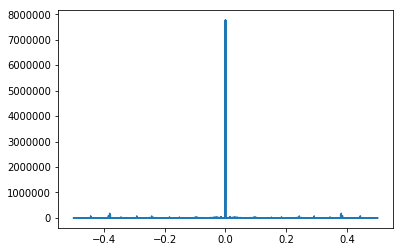

In [37]:
freq = fft.fftfreq(len(spectrum))
plt.plot(freq, abs(spectrum))

see

https://www.ritchievink.com/blog/2017/04/23/understanding-the-fourier-transform-by-example/

http://pyageng.mpastell.com/book/spectrum.html

https://python-for-signal-processing.blogspot.com/

https://community.plm.automation.siemens.com/t5/Testing-Knowledge-Base/Digital-Signal-Processing-Sampling-Rates-Bandwidth-Spectral/ta-p/402991

Text(0.5, 0, 'Sample number')

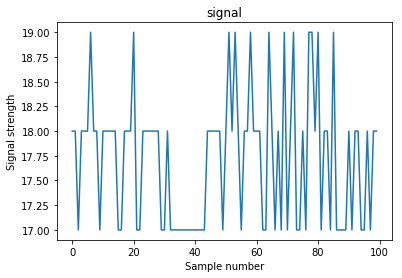

In [38]:
plt.plot((y)[0:100])
plt.title('signal')
plt.ylabel('Signal strength')
plt.xlabel('Sample number')

In [39]:
f, Sk = signal.periodogram(y, nfft = 1024, return_onesided = True, scaling = "spectrum")

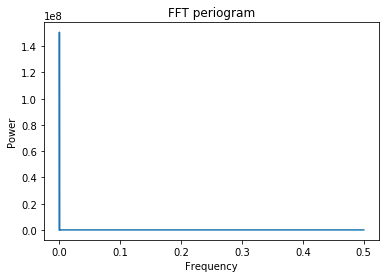

In [40]:

pyageng.pfft(y)

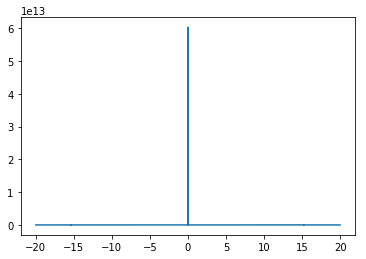

In [41]:
ps = np.abs(np.fft.fft(y))**2

time_step = sr*1000000
freqs = np.fft.fftfreq(y.size, time_step)
idx = np.argsort(freqs)

plt.plot(freqs[idx], ps[idx])

#### spectrogram

https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html

In [42]:
y=y.values

In [43]:
from skimage import util

M = 1024

slices = util.view_as_windows(y, window_shape=(M,), step=100)
print(f'y shape: {y.shape}, Sliced y shape: {slices.shape}')

y shape: (800000,), Sliced y shape: (7990, 1024)


In [44]:
win = np.hanning(M + 1)[:-1]
slices = slices * win

In [45]:
slices = slices.T
print('Shape of `slices`:', slices.shape)

Shape of `slices`: (1024, 7990)


For each slice, calculate the DFT, which returns both positive and negative frequencies (more on that in “Frequencies and Their Ordering”), so we slice out the positive M2 frequencies for now.

In [46]:
spectrum = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
spectrum = np.abs(spectrum)

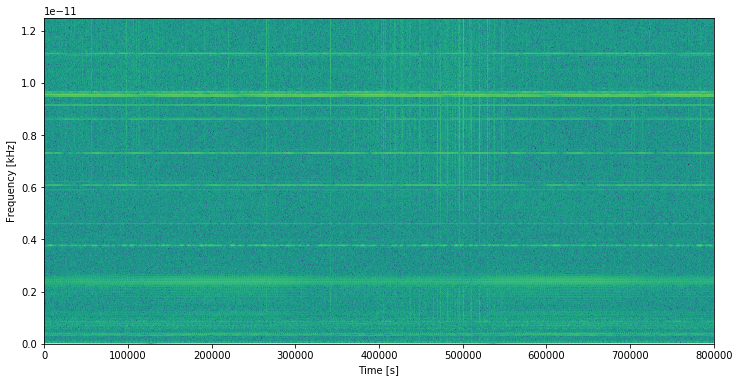

In [47]:
f, ax = plt.subplots(figsize=(12, 6))

S = np.abs(spectrum)
S = 20 * np.log10(S / np.max(S))

ax.imshow(S, origin='lower', cmap='viridis',
          extent=(0, len(y), 0, sr / 2 / 1000))
ax.axis('tight')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

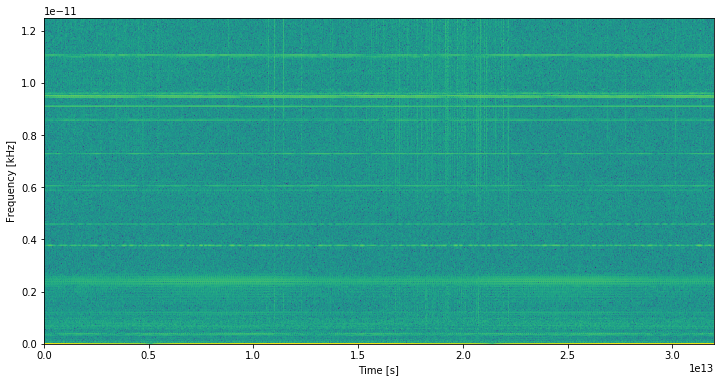

In [49]:
from scipy import signal

freqs, times, Sx = signal.spectrogram(y, fs=sr, window='hanning',
                                      nperseg=1024, noverlap=M - 100,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(12, 6))
ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]');

In [63]:
def plotTS(data, periodlength, vmin, vmax, name='plot'):
    fig, axes = plt.subplots(figsize = [14, 4], dpi = 100, nrows = 1, ncols = 1)
    stacked, timeindex = tsam.unstackToPeriods(copy.deepcopy(data), periodlength)
    cax = axes.imshow(stacked.values.T, interpolation = 'nearest', vmin = vmin, vmax = vmax)
    axes.set_aspect('auto')  
    axes.set_ylabel('high freq')
    plt.xlabel('20ms')

    fig.subplots_adjust(right = 1.2)
    cbar=plt.colorbar(cax)    
    cbar.set_label('energy')
    #plt.savefig('plots/clustering/{0}.png'.format(name))
    plt.show()

In [127]:
y0=train_df.iloc[0, :]

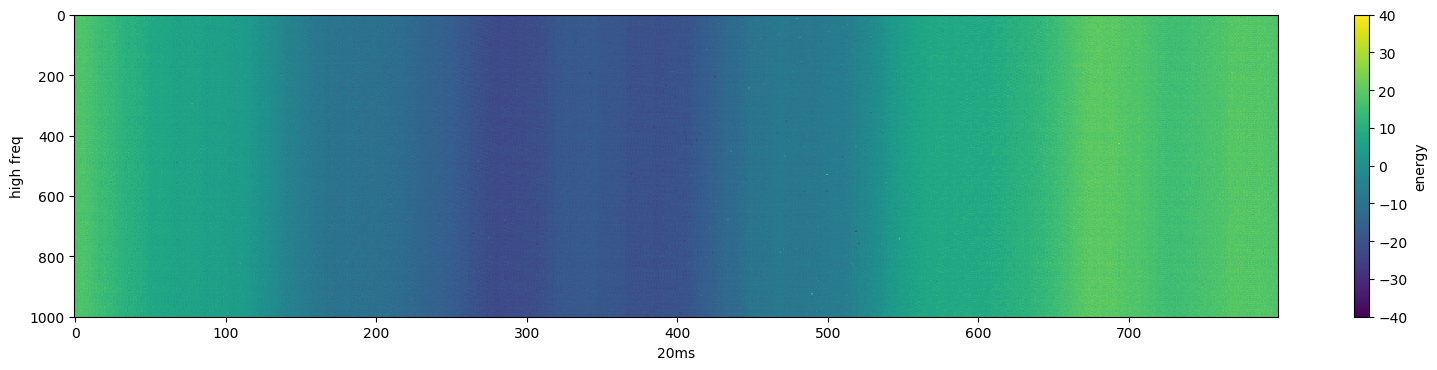

In [100]:
plotTS(y0, 1000, vmin =-40, vmax = 40)

In [101]:
y3_bad=train_df.iloc[3, :]

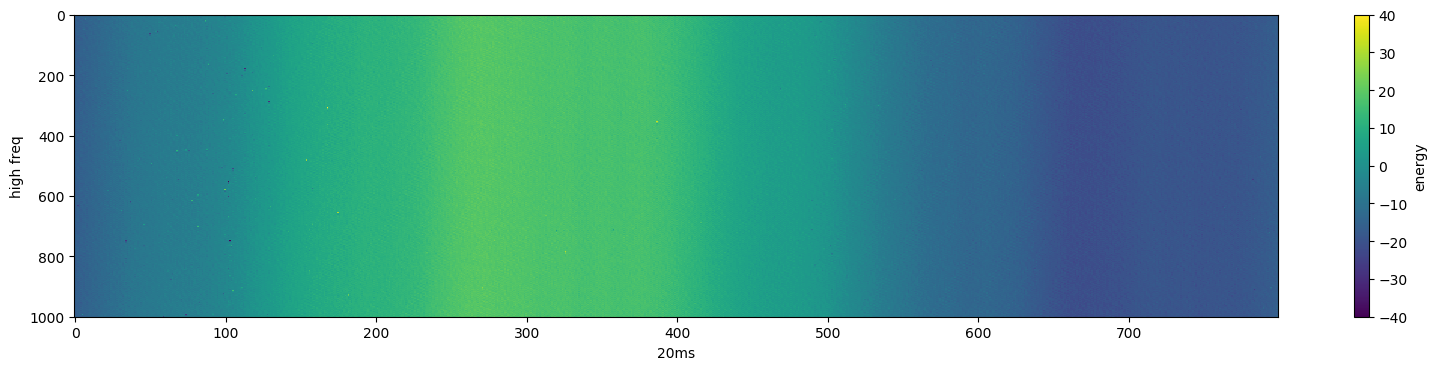

In [102]:
plotTS(y3_bad, 1000, vmin =-40, vmax =40)

In [103]:
y1=train_df.iloc[1, :]

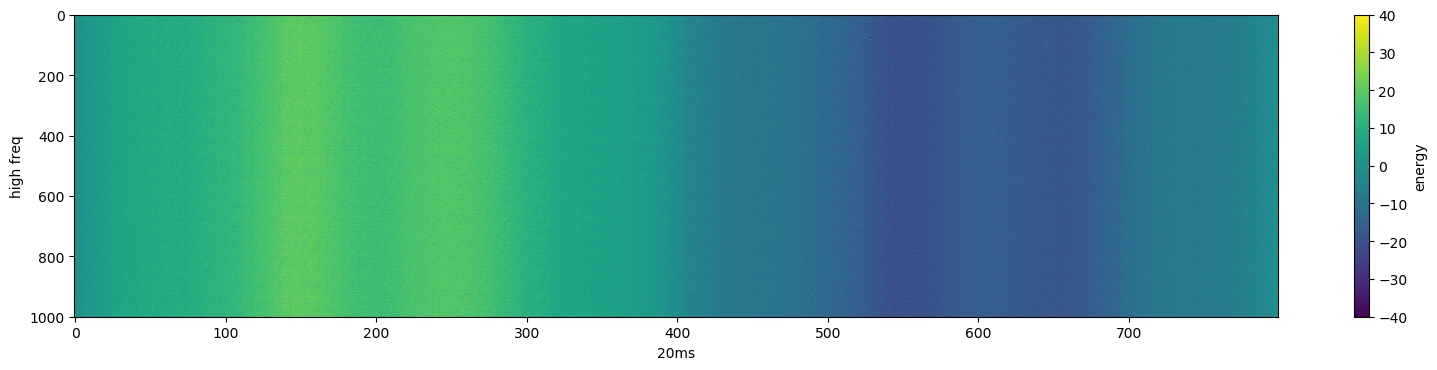

In [104]:
plotTS(y1, 1000, vmin =-40, vmax =40)

In [105]:
y3_bad=train_df.iloc[3, :]

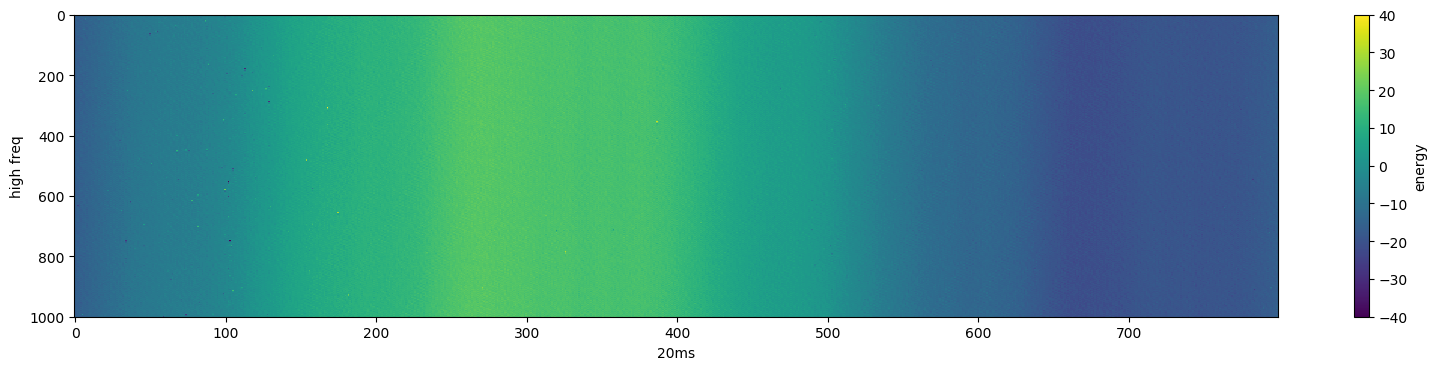

In [106]:
plotTS(y3_bad, 1000, vmin =-40, vmax =40)

In [107]:
y2=train_df.iloc[2, :]

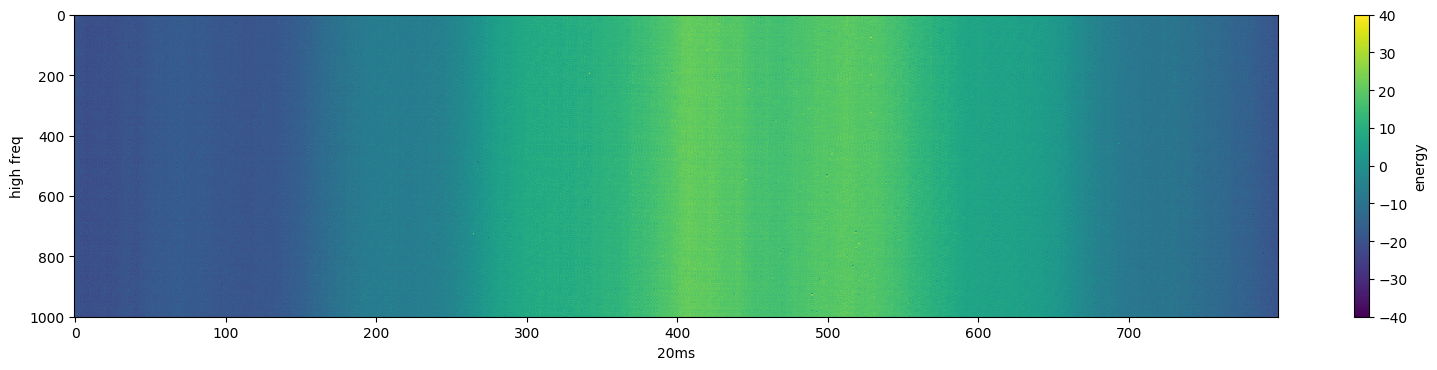

In [108]:
plotTS(y2, 1000, vmin =-40, vmax =40)

In [128]:
y4_bad=train_df.iloc[4, :]

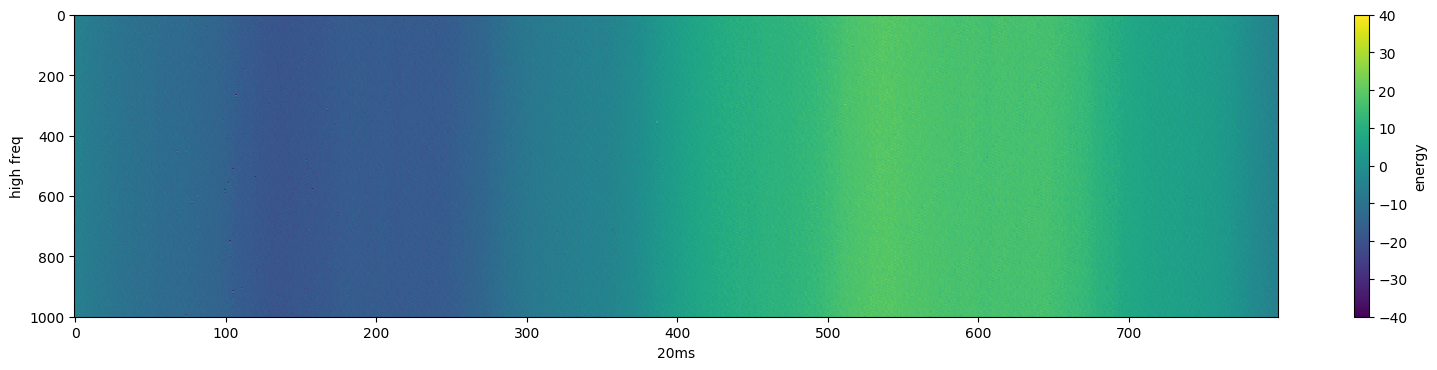

In [110]:
plotTS(y4_bad, 1000, vmin =-40, vmax =40)

In [129]:
y0=y0[0:10000]
y4_bad=y4_bad[0:10000]

#### dtw

In [134]:
gc.collect()

9997

In [135]:
d, paths = dtw.warping_paths(y1, y3_bad, window=500, psi=2)

MemoryError: 

In [131]:
best_path = dtw.best_path(paths)

(<Figure size 720x720 with 4 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7f0d1b963438>])

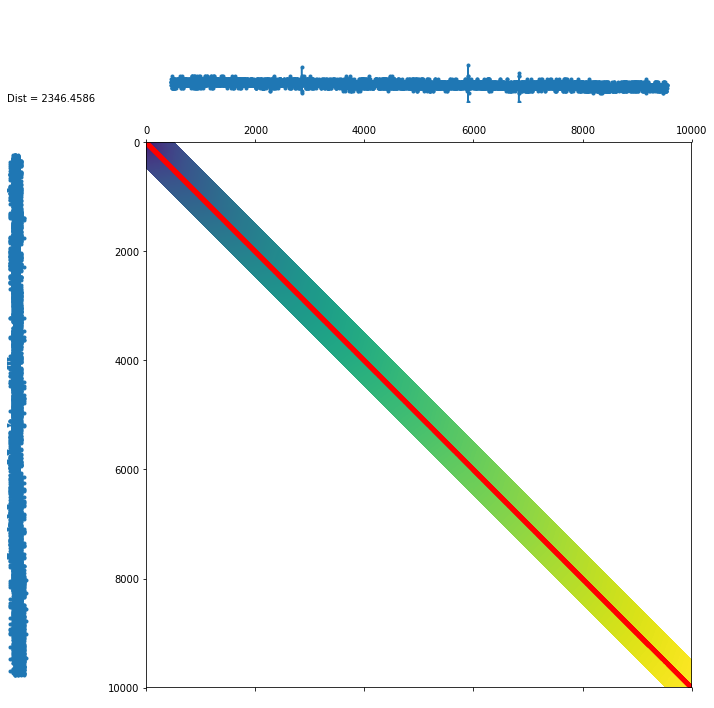

In [132]:
dtwvis.plot_warpingpaths(y0, y4_bad, paths, best_path)

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GASF, GADF

# Parameters
n_samples, n_features = 100*10, 144*10

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_features)
X.shape


(1000, 1440)

In [ ]:
# GAF transformations
image_size = 240
gasf = GASF(image_size)
X_gasf = gasf.fit_transform(X)
gadf = GADF(image_size)
X_gadf = gadf.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
plt.title("GASF", fontsize=16)
plt.subplot(122)
plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
plt.title("GADF", fontsize=16)
plt.show()

In [59]:
len(y)

800000

In [64]:
def gasf_plot(X):
    # GAF transformations
    image_size = 240
    gasf = GASF(image_size)
    X_gasf = gasf.fit_transform(X)
    gadf = GADF(image_size)
    X_gadf = gadf.fit_transform(X)

    # Show the results for the first time series
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
    plt.title("GASF", fontsize=16)
    plt.subplot(122)
    plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
    plt.title("GADF", fontsize=16)
    plt.show()

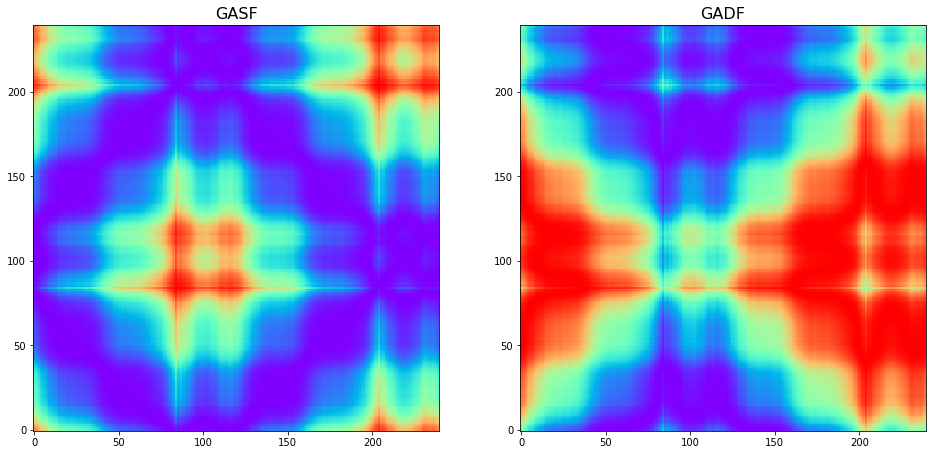

In [65]:
#get first channel
y=train_df.iloc[0, :]
X = (y, y)
gasf_plot(X)


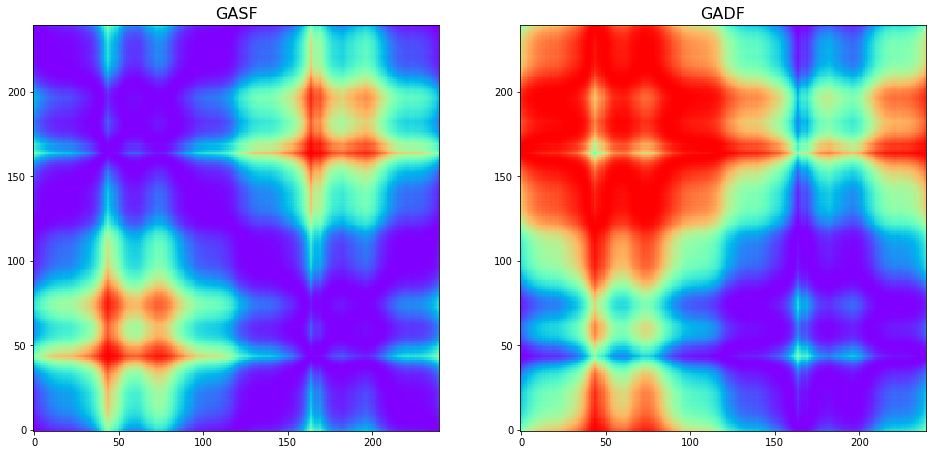

In [67]:
y=train_df.iloc[1, :]
X = (y, y)
gasf_plot(X)

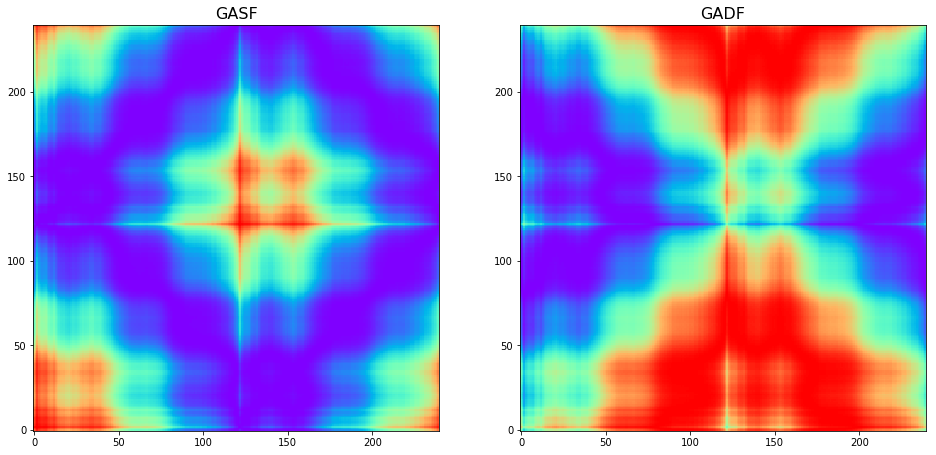

In [68]:

y=train_df.iloc[2, :]
X = (y, y)
gasf_plot(X)

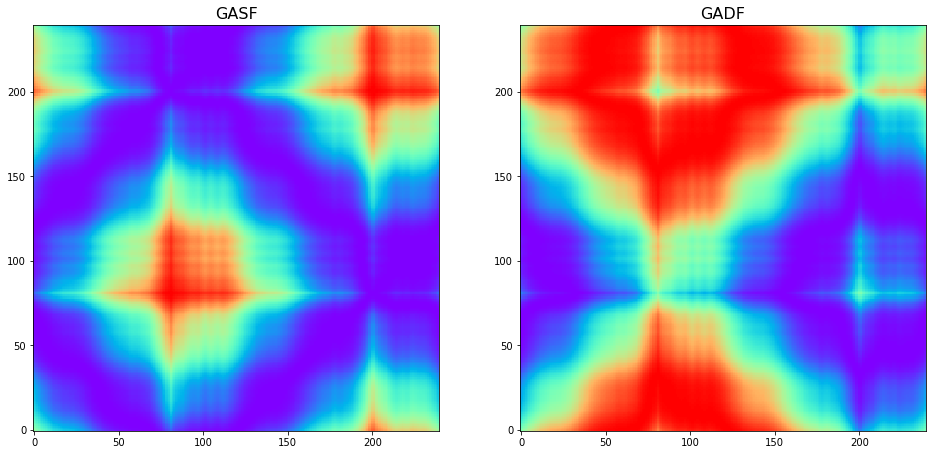

In [69]:
y=train_df.iloc[3, :]
X = (y, y)
gasf_plot(X)